# Formula 1 2020 Driver Consistency

Author: Gabriel (Alex) Palermo
last edit: 10/31/2020


## Introduction

In the formula 1 championship, consistency is key to winning championships for the top drivers / teams and to winning the one-off podium for midfield teams when the top runners do make mistakes (case in point: this year's Italian grand prix). In order to characterize the relative consistency between drivers, we'll generate box plots of the aggregated lap times for one driver across a full race. The idea behind this is that the most consistent drivers should have the smallest spread of lap times over the course of the race, when all the extenuating variables are taken into account (pit stops, tire choice, ect.).

I've decided to use this notebook as a platform to practice SQL queries, which brings some complications from using pandas dataframes. Mainly, this notebook as published will be read-only, since the database is on my local computer and not published on a server. At a later time I will include instructions and an additional script for downloading the datasets from kaggle and initializing the database so that others may add to it. 

TODO: 
- update team colors and driver names for historical data; handle cases where the 3-letter driver code is unavailable
- Pair drivers according to team, order teams according to championship standings
- hihglight race winner on axis
- filter out drivers that did not finish
- control for tire choice (will need to find another dataset to plot this)

In [35]:
# import libraries

import numpy as np
import pandas as pd
from psycopg2 import connect, extensions, sql
from IPython.display import clear_output
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime, time, date
from collections import defaultdict

with open("postgres_login_info.txt") as f: 
    login_info = f.read()
mpl.rcParams['figure.max_open_warning'] = 50

In [36]:
# Define a function to run a query

def query(text):
    """Run a query on the Formula_1_statistics database using the text input"""
    with connect(login_info) as conn, conn.cursor() as cur:  
        autocommit = extensions.ISOLATION_LEVEL_AUTOCOMMIT
        conn.set_isolation_level(autocommit)
        
        query = sql.SQL(text)
        cur.execute(query)
        return pd.DataFrame(cur.fetchall(), columns = [desc[0] for desc in cur.description])

In [37]:
# return the lap times for 1 driver over 1 race, filtering out pit stops and safety car periods, which are defined as a lap
# time above a certain percentage of the fastest lap of the race (20% by default). This allows drivers to still be 
# peanilized for various spins and shunts

def get_lap_distribution(firstname=None, lastname=None, driverref=None, race_name=None, year=None, cutoff=1.2): 
    """Run a query to find the lap times for a driver over the course of 1 race"""
    
    text = f"""
    
    -- construct gp info
    WITH gps AS (SELECT EXTRACT(MINUTES FROM lap_times.time)*60 +
                            EXTRACT(SECONDS FROM lap_times.time) AS lap_time, 
                        lap_times.lap, 
                        lap_times.position, 
                        lap_times.driverid, 
                        lap_times.raceid,
                        EXTRACT(YEAR FROM races.date) AS year
                 FROM lap_times 
                 JOIN races ON lap_times.raceid = races.raceid 
                 JOIN circuits ON races.circuitid = circuits.circuitid
                 WHERE ((races.name iLike '%{race_name}%') AND year = {year})
                 ), 
                 
    -- construct pit info
    pits AS (SELECT pit_stops.driverid, 
                    pit_stops.raceid, 
                    pit_stops.stop, 
                    pit_stops.lap AS pit_lap, 
                    pit_stops.time, 
                    pit_stops.duration
             FROM pit_stops
             JOIN races ON pit_stops.raceid = races.raceid
             JOIN drivers ON pit_stops.driverid = drivers.driverid
             WHERE(
                  (races.name iLike '%{race_name}%') 
                   AND year = {year}
                   AND ((drivers.forename iLike '%{firstname}%'
                       AND drivers.surname iLike '%{lastname}%') 
                        OR drivers.driverref iLike '%{driverref}%')
              )
    ),
    
    
    -- find the fastest lap to filter safety car laps
    fastest_lap AS (SELECT MIN(gps.lap_time) AS time FROM gps) 
        
    -- put it all together
    SELECT gps.year, 
           gps.lap, 
           gps.lap_time,
           gps.position,
           drivers.code,
           races.name
    FROM drivers 
    JOIN gps ON drivers.driverid = gps.driverid
    JOIN races ON gps.raceid = races.raceid
    WHERE(
        ((drivers.forename iLike '%{firstname}%' 
        AND drivers.surname iLike '%{lastname}%')
        OR drivers.driverref iLike '%{driverref}%')
        AND gps.lap NOT IN (SELECT pits.pit_lap FROM pits)
        AND gps.lap_time < {cutoff} * (SELECT fastest_lap.time FROM fastest_lap)
        )
    ORDER BY gps.lap
    """
    
    df = query(text)
    
    return df
#get_lap_distribution(firstname="Lewis", lastname="Hamilton", race_name="British", year=2020)

In [38]:
# get the lap time distribution for every driver over a race

def get_race_distribution(race_name, year, cutoff=1.2):
    """Query a dataframe to get the lap times of every driver on the grid over the course of a race"""
    drivers_text = f"""
    SELECT drivers.forename AS firstname,
           drivers.surname AS lastname,
           drivers.code, 
           drivers.driverid, 
           drivers.driverref,
           races.name AS race_name, 
           constructors.name AS team
    FROM drivers
    JOIN results ON results.driverid = drivers.driverid
    JOIN races ON races.raceid = results.raceid
    JOIN constructors ON constructors.constructorid = results.constructorid
    WHERE races.year = {year} AND races.name iLike '%{race_name}%'
    """
    
    drivers_df =  query(drivers_text);
    frames = [get_lap_distribution(driverref=ref, race_name=race_name, year=year, cutoff=cutoff) 
              for ref in drivers_df['driverref']];
    lap_time_results = pd.concat(frames).sort_values(by="lap_time")
    lap_time_results['team'] = [drivers_df[drivers_df['code'] == i]['team'].values[0] for i in lap_time_results['code']]
    
    return lap_time_results

In [39]:
# Make a plot of all the lap distributions for a race

def plot_race_distribution(race_name, year, outliers=False, whis=1.5, cutoff=1.2, direction = "vert"): 
    """Plot the distribution of lap times over the course of a race"""
    df = get_race_distribution(race_name=race_name, year=year, cutoff=cutoff);
    
    fastest_lap = df['lap_time'].min()
    slowest_lap = df['lap_time'].max()
    
    df.sort_values(by="team")
    
    sns.set_theme(style="ticks")
    
    colors = defaultdict(lambda: '#FFFFFF', {
        'Mercedes'    : '#00D2BE', 
        'Ferrari'     : '#C00000', 
        'Red Bull'    : '#0600EF', 
        'Renault'     : '#FFF500', 
        'Haas F1 Team': '#787878', 
        'Racing Point': '#F596C8', 
        'Force India' : '#F596C8', 
        'AlphaTauri'  : '#C8C8C8',
        'Toro Rosso'  : '#469BFF',
        'McLaren'     : '#FF8700', 
        'Alfa Romeo'  : '#960000',
        'Sauber'      : '#960000',
        'Williams'    : '#0082FA'
    })
    
    %config InlineBackend.figure_format = 'svg'
    
    if direction=="vert":
        fig, ax = plt.subplots(figsize=[9, 4])
        sns.boxplot(ax=ax,
                    data=df,
                    y="lap_time", 
                    x="code", 
                    hue="team", 
                    palette=colors, 
                    showfliers=outliers,
                    whis=1.5,
                    dodge=False 
                    );

        ax.legend(#loc='upper center',
                  bbox_to_anchor=(1,1),
                  ncol=1,  
                  fontsize=12)

        ax.set_xlabel("driver", fontsize=12)
        ax.set_ylabel("lap time (seconds)", fontsize=12),
        ax.set_ylim([(fastest_lap-0.5), fastest_lap*(cutoff)+2])
    else: 
        fig, ax = plt.subplots(figsize=[4.8, 15])
        sns.boxplot(ax=ax,
                    data=df,
                    y="code", 
                    x="lap_time", 
                    hue="team", 
                    palette=colors, 
                    showfliers=outliers,
                    whis=1.5,
                    dodge=False 
                    );

        ax.legend(loc='upper left', 
                  ncol=1,  
                  fontsize=15, 
                  )

        ax.set_ylabel("driver", fontsize=12)
        ax.set_xlabel("lap time (seconds)", fontsize=12),
        ax.set_xlim([(fastest_lap-0.5), fastest_lap*(cutoff)])
    ax.tick_params(labelsize=10)
    ax.set_title(f"Lap time distribution for the {year} {df['name'].values[0]}\n", fontsize=15)
    return ax, df

In [40]:
# plot all the races in a season

def plot_all_races(year, cutoff=1.15, outliers=True):
    text = f"""
    SELECT name
    FROM races
    WHERE year = {year}
    ORDER BY round
    """

    df = query(text)
    for race in df['name']: 
        try: 
            plot_race_distribution(race, year, cutoff=cutoff, outliers=outliers)
        except Exception as e: 
            print(f"no data for {race}")
            print(str(e))

no data for Eifel Grand Prix
No objects to concatenate
no data for Portuguese Grand Prix
No objects to concatenate
no data for Emilia Romagna Grand Prix
No objects to concatenate
no data for Turkish Grand Prix
No objects to concatenate
no data for Bahrain Grand Prix
No objects to concatenate
no data for Sakhir Grand Prix
No objects to concatenate
no data for Abu Dhabi Grand Prix
No objects to concatenate


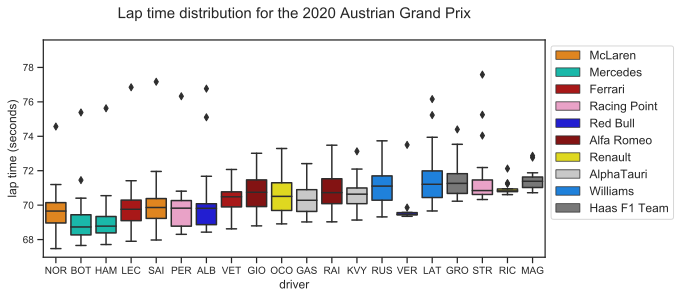

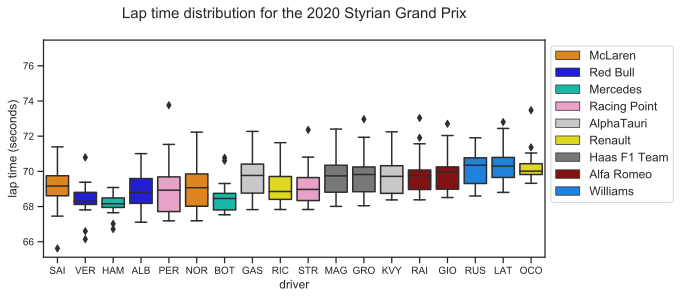

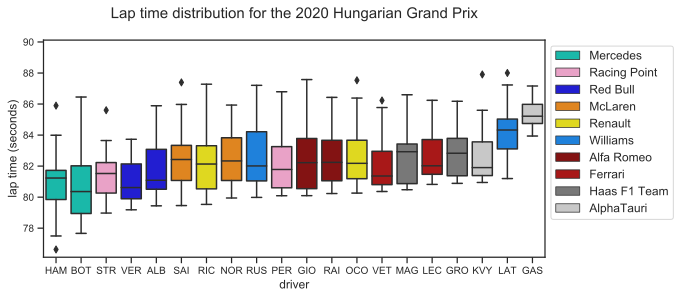

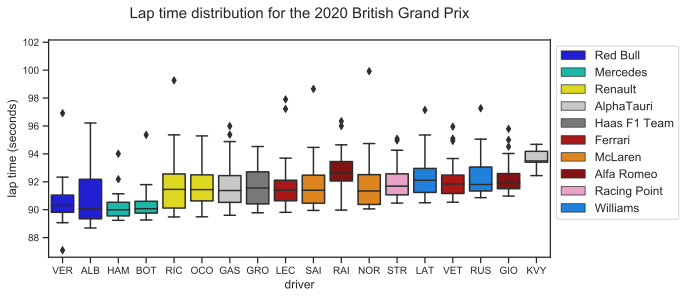

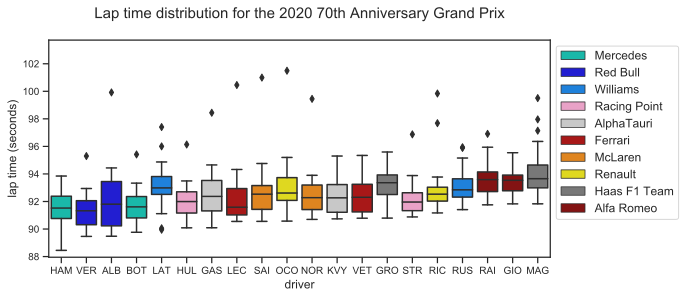

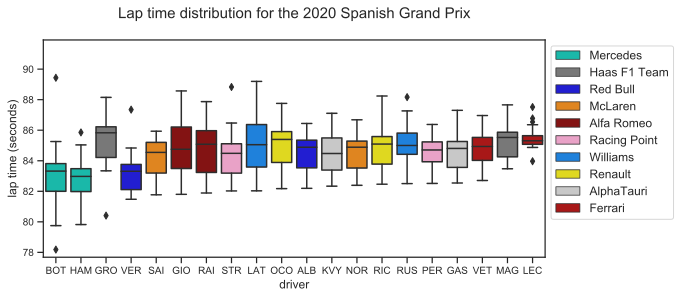

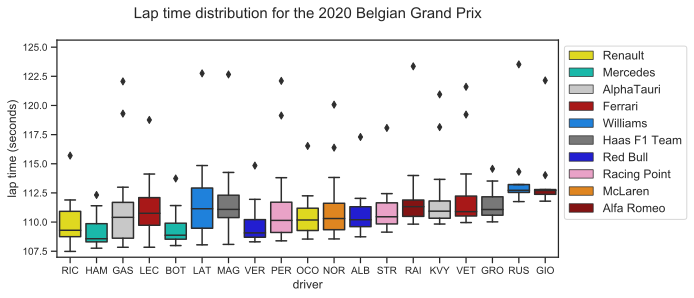

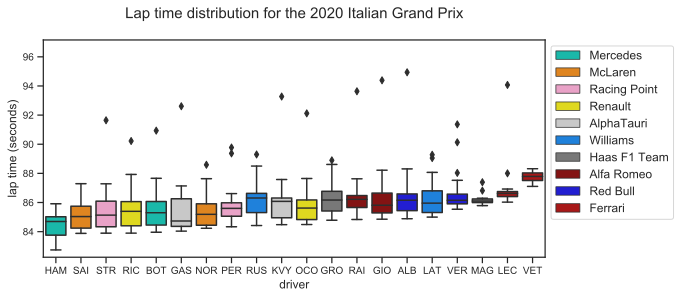

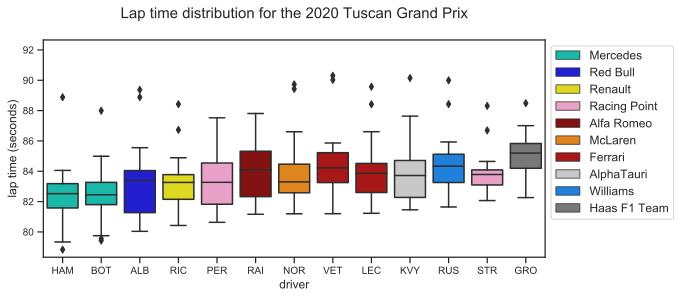

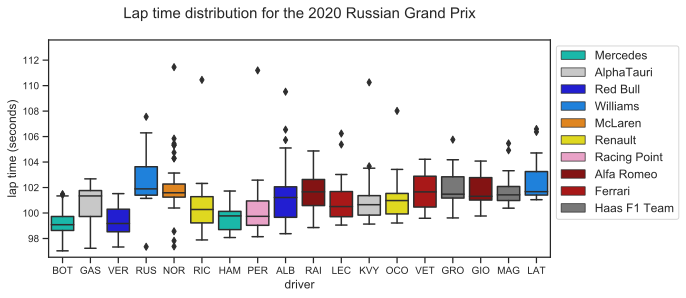

In [41]:
plot_all_races(2020, cutoff=1.15, outliers=True)

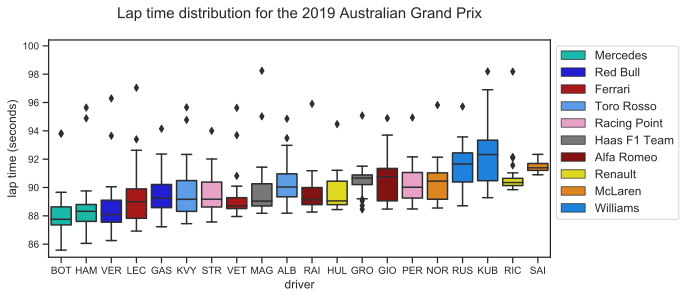

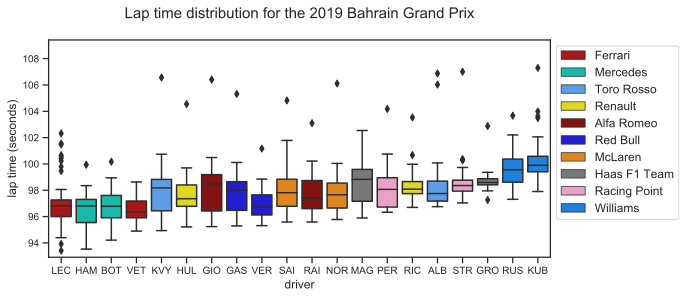

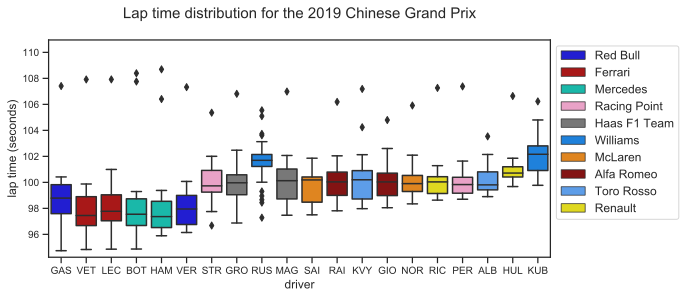

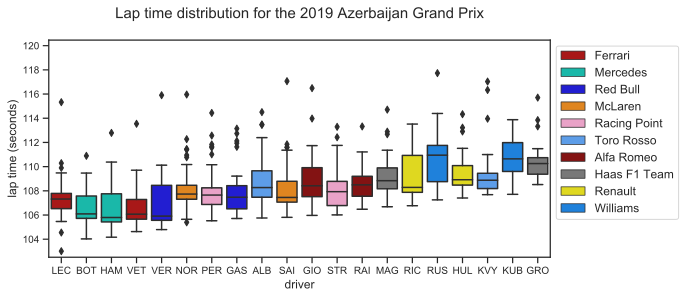

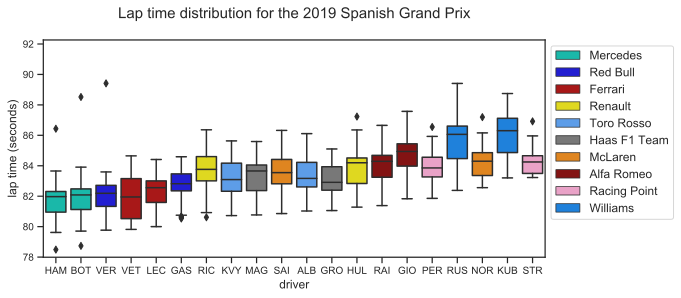

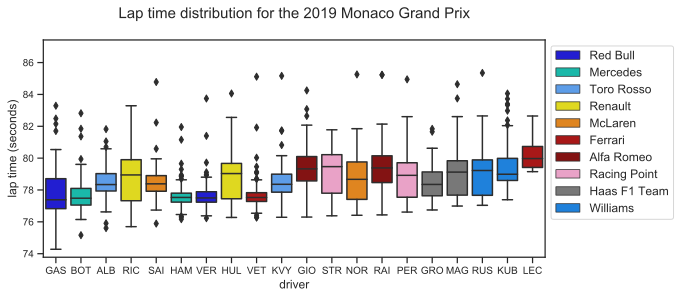

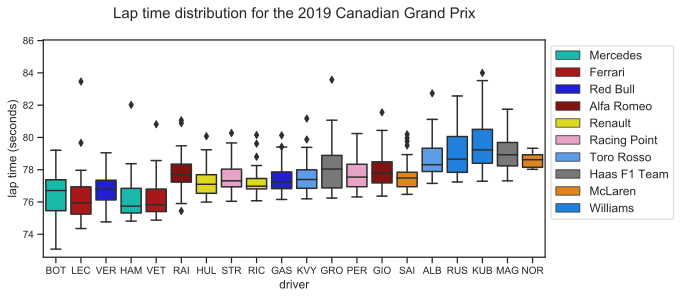

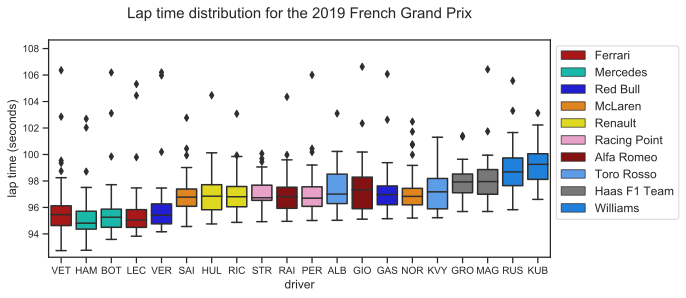

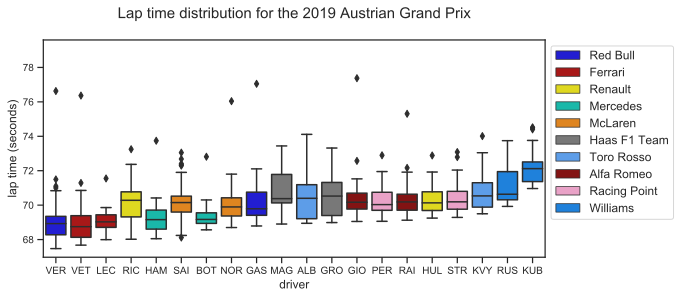

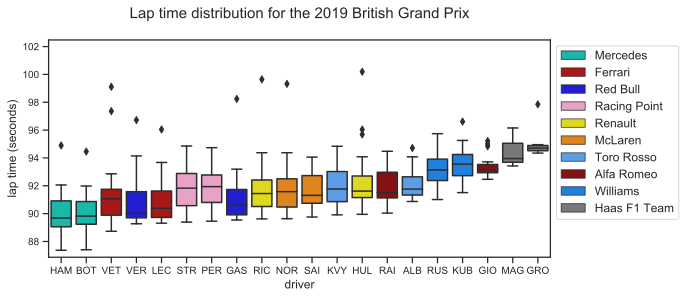

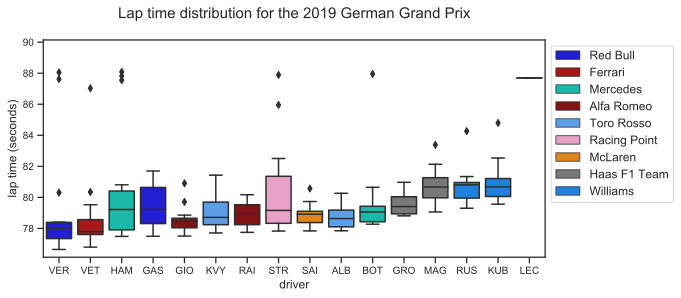

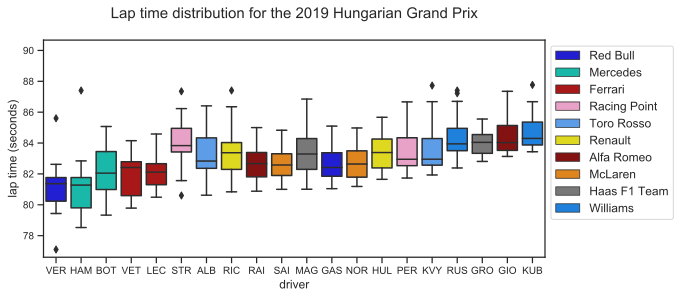

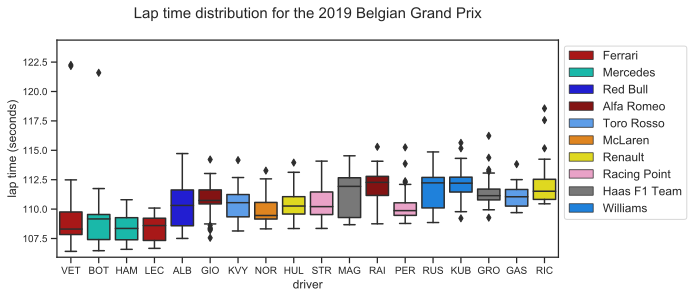

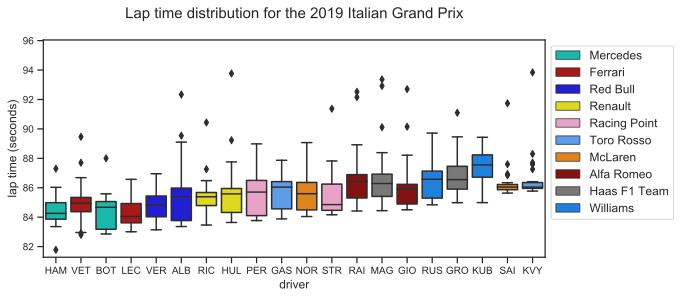

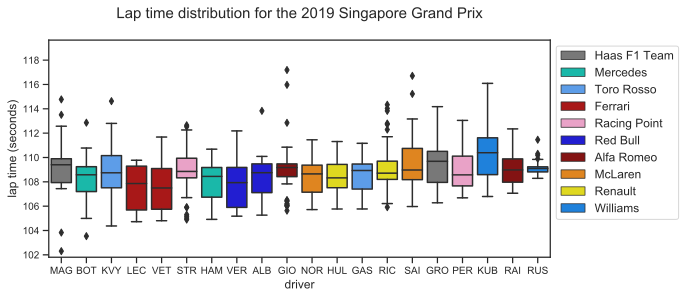

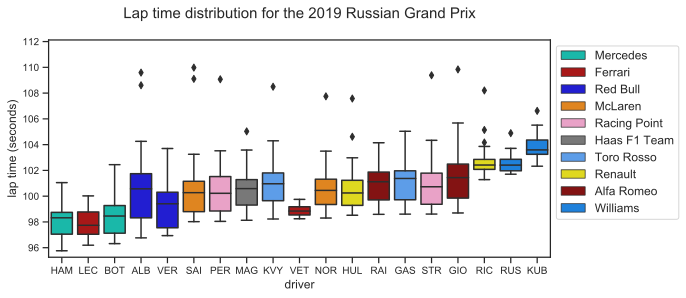

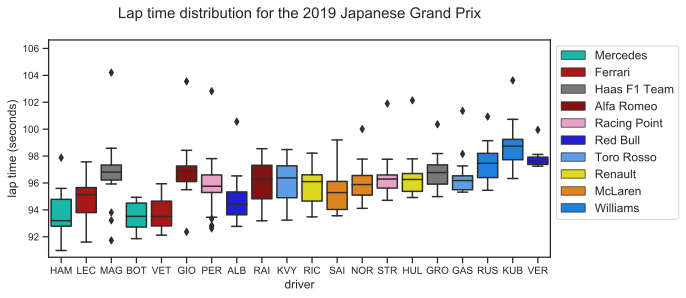

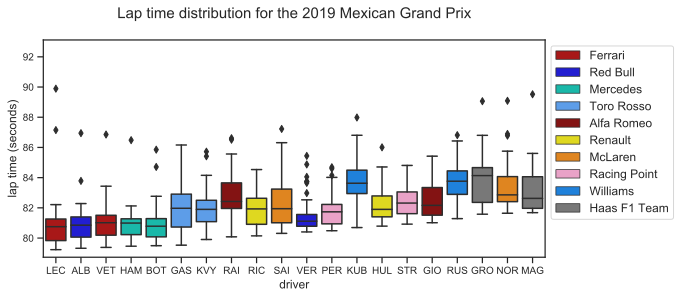

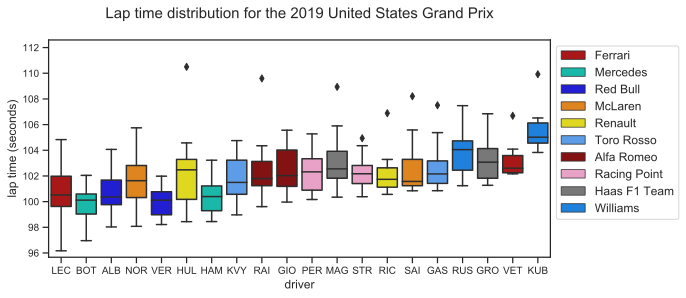

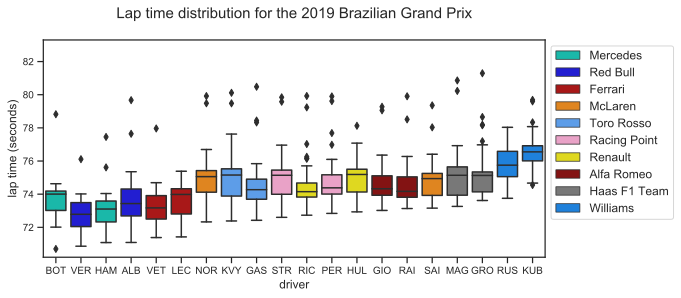

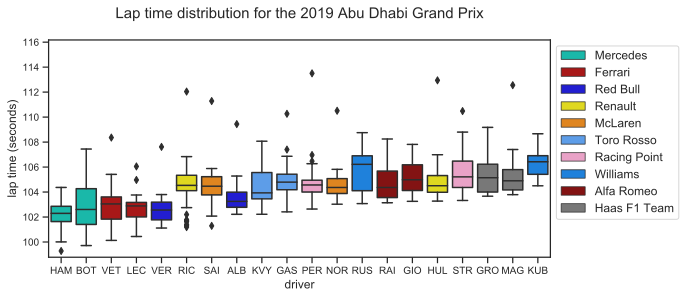

In [42]:
plot_all_races(2019, cutoff=1.15, outliers=True)

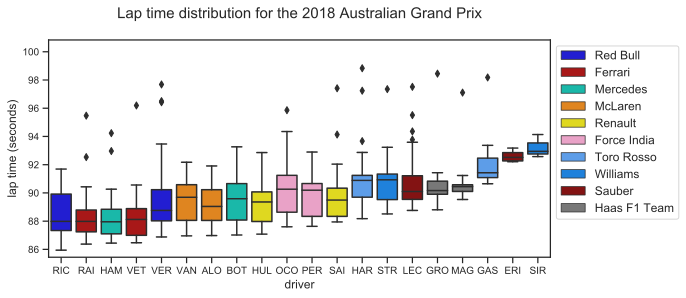

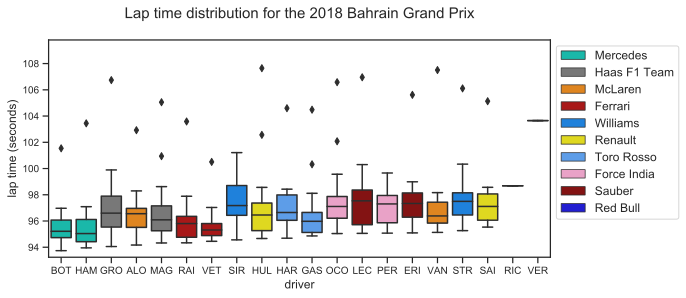

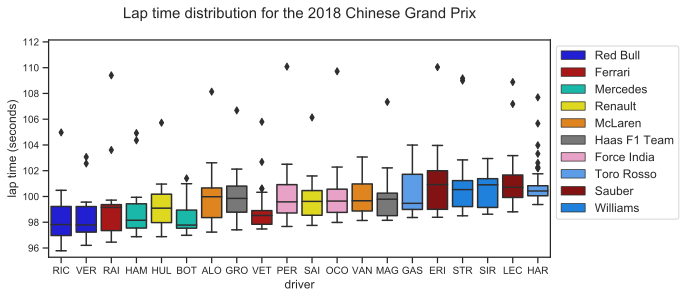

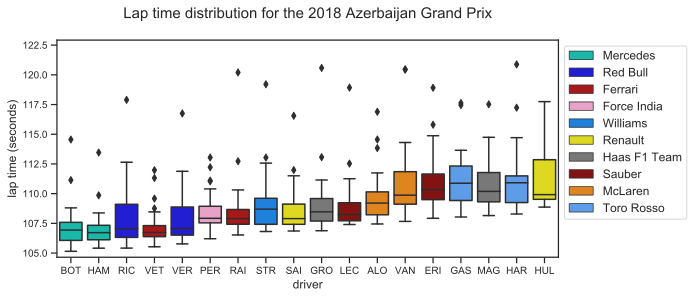

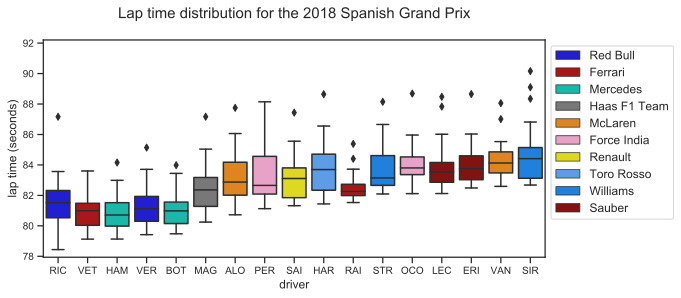

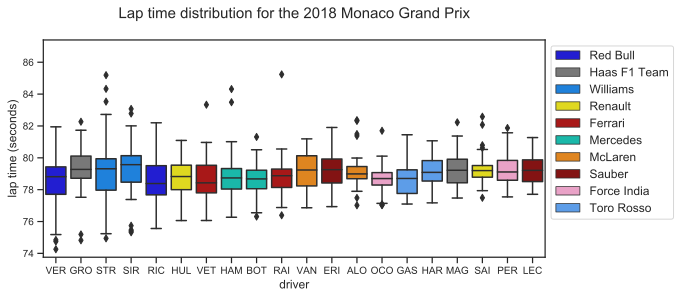

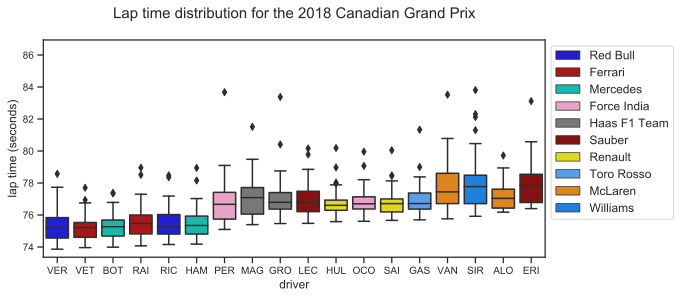

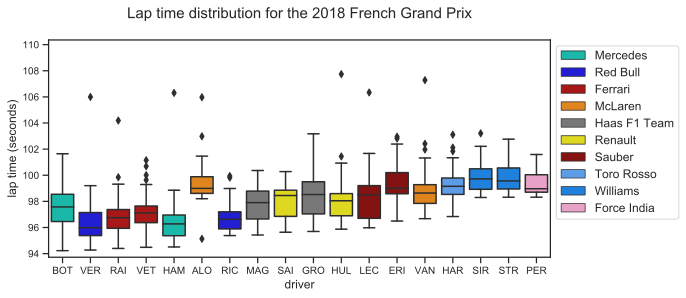

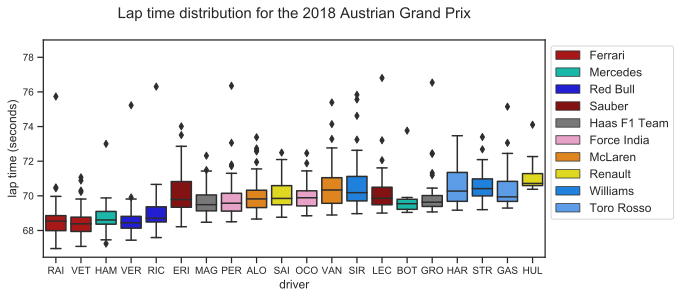

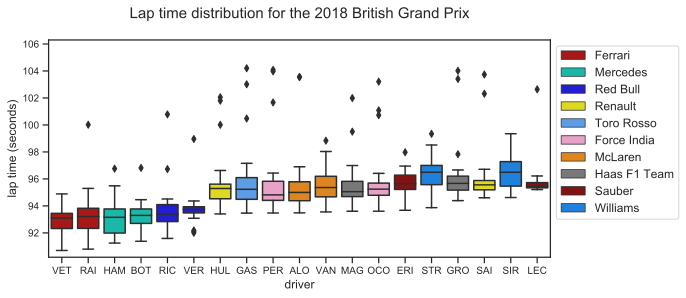

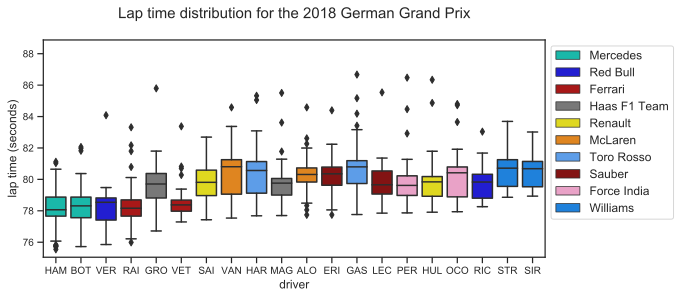

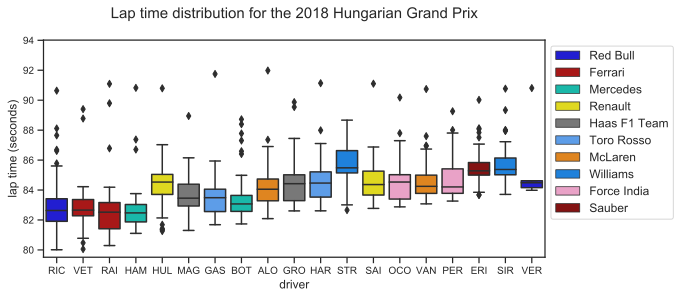

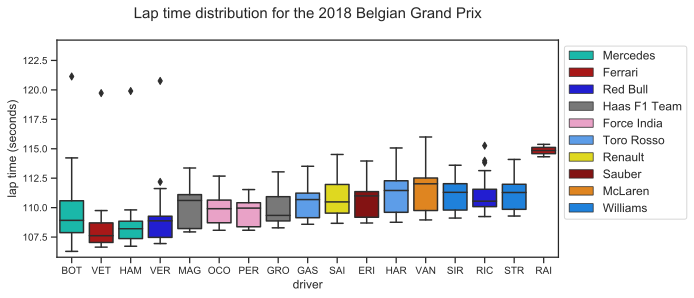

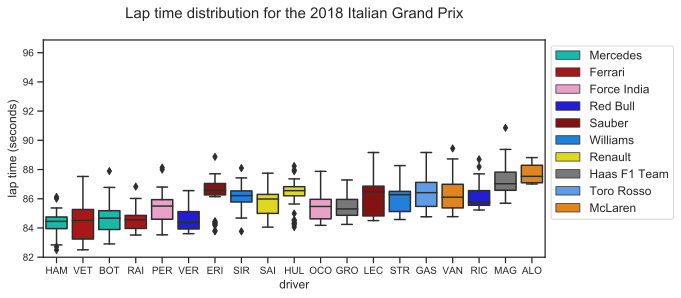

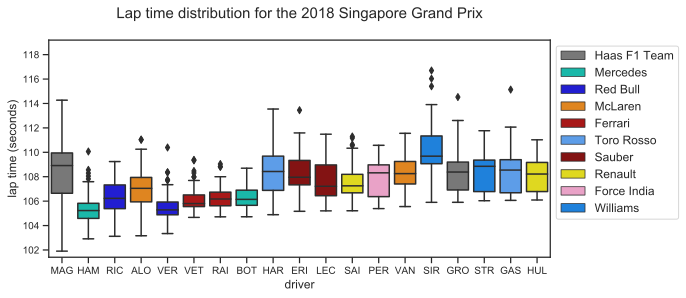

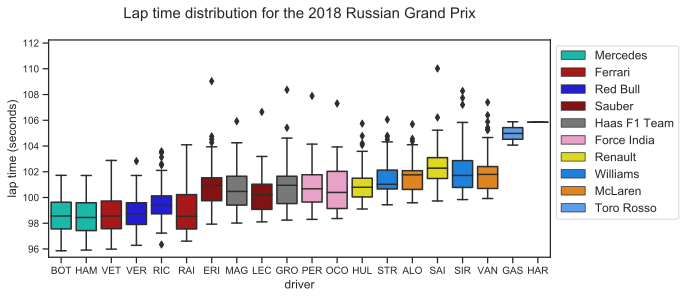

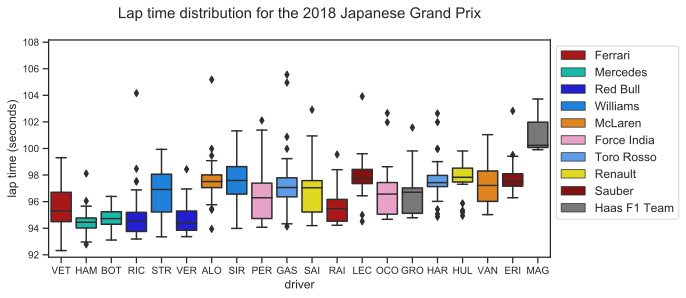

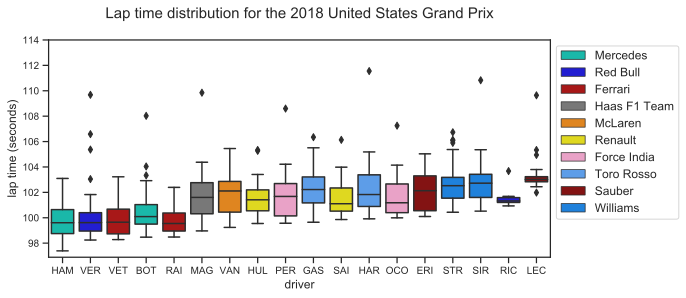

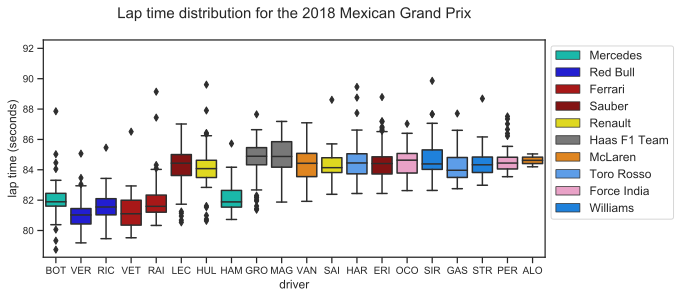

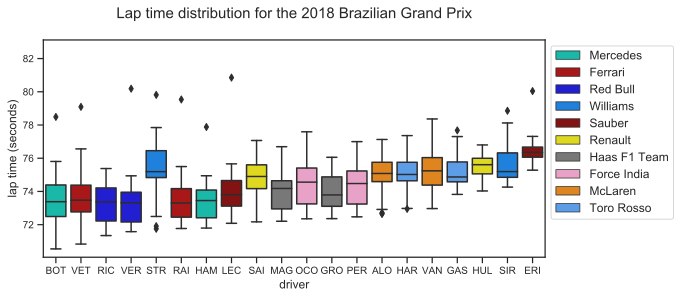

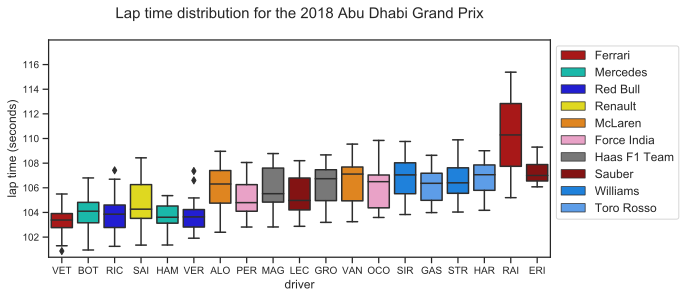

In [43]:
plot_all_races(2018, cutoff=1.15, outliers=True)